0.8723283178856399
Z = 26071.09489460951
y = 8.0
optimal number of watts to install is: 2520.0 W
Total Captial Cost: $9556.0


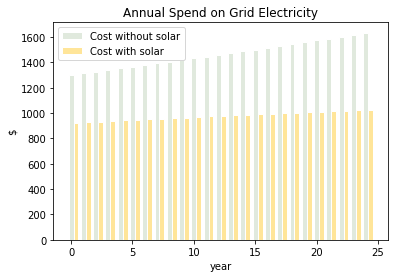

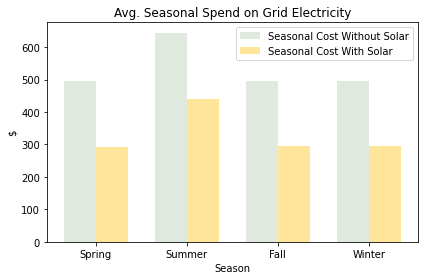

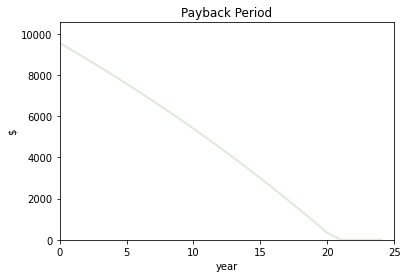

"\n# carbon footprint tradeoff\noptions = ('Without Solar', 'With Solar')\ny_pos = np.arange(len(options))\n\ndemandWithSolar = []\nfor t in range(T):\n    demandWithSolar.append(max(0, (E[t] - ((numPanels * P * 0.146 * 24 * U * 365) * (1 - d[t])))))  # will need to change to Gt\n\nprint(np.sum(E))\nprint(np.sum(demandWithSolar))\nperformance = [np.sum(E)*0.0003916, np.sum(demandWithSolar)*0.0003916]\nplt.bar(y_pos, performance, align='center', alpha=0.5, color='#ffe599ff')\nplt.xticks(y_pos, options)\nplt.ylabel('CO2 kg')\nplt.title('Carbon Footprint Tradeoff over 25 years')\n\nplt.show()\n"

In [27]:
# installing and importing mip
#!pip install --user mip
from mip import *
import math
import matplotlib.pyplot as plt
import numpy as np

# defining parameters
E0 = 2200000  # spring electricity usage (W) from user
E = [[E0, (E0*1.3), E0, E0]]  # seasonal electricity usage (W) with trend
G = [[0.00017952, 0.00017952, 0.00017952, 0.00017952]] #cost of electricity from the grid at year 0($/W)
m = [[10,10,10,10]]  # yearly maintenance cost ($/panel)
B = 10000  # budget from user
C = 315*2.80  # cost of each solar panel ($/panel) (12 modules of 60cell)
Ap = 18.9  # area of solar panel (ft^2) (40 * 68 inches)
Ar = 1700  # area of the roof (ft^2) from user
Armax = (Ar / 2) * 0.8
P = 315 # capacity of each solar panel (W) per hour
F = 2500  # fixed costs of installing solar panels
d = []  # deterioration factor at year i (%)
T = 25  # lifespan of solar panels
S = 3 # 0, 1, 2, 3 = “Spring”, “Summer”, “Fall”, “Winter”
L = [92, 92, 91, 90] # number of days within each quarter

#filling in cost of electricity values (remain constant throughout seasons)
for t in range(1, T):
    yearly_cost = G[t - 1][0] + (G[t - 1][0] * 0.02)
    G.append([yearly_cost, yearly_cost, yearly_cost, yearly_cost])

# filling in depreciation values (remain constant throughout seasons)
for t in range(T):
    yearly_depreciation = (0.0007/4) * t
    d.append([yearly_depreciation, yearly_depreciation, yearly_depreciation, yearly_depreciation])

# function to fill in Et - linearly decreases by 1.03% !!! change
for t in range(1, T):
    yearly_decrease_spring = E[t - 1][0] - (E[t - 1][0] * 0.0103)
    yearly_decrease_summer = E[t - 1][1] - (E[t - 1][1] * 0.0103)
    yearly_decrease_fall = E[t - 1][2] - (E[t - 1][2] * 0.0103)
    yearly_decrease_winter = E[t - 1][3] - (E[t - 1][3] * 0.0103)
    E.append([yearly_decrease_spring, yearly_decrease_summer, yearly_decrease_fall, yearly_decrease_winter])

# calculating U
# define variables
soiling = 0.02  # loses due to dirt/dust on panels (higher for high pollution, low rainfall areas)
shading = 0.03  # might change to be an input from users
snow = 0  # assume that homeowner will clear snow from panels
mismatch = 0.02  # electrical losses due to manufacturing
wiring = 0.02  # loss between DC and AC conversion
connections = 0.005  # loss between electrical connectors
nameplaterating = 0.01
availability = 0.03

# dividy by 4 to get quarterly U value
# how much energy can be used (%) (factors: irradiation, shadow, direction)
U = ((1 - soiling) * (1 - shading) * (1 - snow) * (1 - mismatch) * (1 - wiring) * (1 - connections) * (
        1 - nameplaterating) * (1 - availability))
print(U)
# convert m into present value (remain constant throughout seasons)
i = 0.00206
for t in range(1,T):
    quarterly_maintainence = (10/((1+i) ** t)/4)
    m.append([quarterly_maintainence, quarterly_maintainence, quarterly_maintainence, quarterly_maintainence])

# capacity factor each season TO-DO
H = [0.146, 0.146, 0.146, 0.146] 

# find max of all seasons using E @ t=0
# number of solar panels needed to fulfill at least 100% of electricity from the grid
P_0 = math.ceil((E[0][0] / L[0]) / (P * H[0] *24 * U) * 0.35)
P_1 = math.ceil((E[0][1] / L[1]) / (P * H[1] *24 * U) * 0.35)
P_2 = math.ceil((E[0][2] / L[2]) / (P * H[2] *24 * U) * 0.35)
P_3 = math.ceil((E[0][3] / L[3]) / (P * H[3] *24 * U) * 0.35)
Pn = max(P_0, P_1, P_2, P_3)  
                            
# initializing model
model = Model()

# initializing decision variable
y = model.add_var(name='y', var_type=INTEGER)  # number of solar panels

# initializing the objective function
model.objective = minimize(xsum((E[t][s] - ((y * P * H[s] *24 * U * L[s]) * (1 - d[t][s]))) * G[t][s] + (m[t][s] * y) for s in range(S) for t in range(T)))
#model.objective = minimize(xsum((E[t][s] - ((y * P * 0.146 *24 * U * 90) * (1 - 0.0007))) * G[t] + (m[t][s] * y) for s in range(S) for t in range(T)))

# adding constraints
model += (y * C) + F <= B  # budget constraint
model += y * Ap <= Armax  # area of roof constraint **NEED TO ADD FACTOR TO CALCULATE USABLE ROOF SIZE**
model += Pn - y >= 0  # fulfill demand constraint
model += y >= 0  # non-negativity constraint

# solving the MIP
status = model.optimize()

# printing solution
if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
    print("Z = {}".format(model.objective_value))
    print("y = {}".format(y.x))  # printing decision variable value
    numWatts = y.x * P
    numPanels = y.x
    print("optimal number of watts to install is: " + str(numWatts) + " W")
    if numPanels > 0:
        totalCost = (numPanels * C) + F
    else:
        totalCost = 0
    print("Total Captial Cost: $" + str(totalCost))
if status == OptimizationStatus.NO_SOLUTION_FOUND:
    print("no feasible solution :(")

# yearly grid energy cost w/o solar vs. yearly grid energy cost w/ solar (grouped bar chart)
# set width of bar
barWidth = 0.40

# set height of each bar
costsWithoutSolar = []
for t in range(T):
    costsWithoutSolarYearly = 0
    for s in range(S):
        costsWithoutSolarYearly = costsWithoutSolarYearly + E[t][s] * G[t][s]
    costsWithoutSolar.append(costsWithoutSolarYearly)
#print(costsWithoutSolar)

costsWithSolar = []
for t in range(T):
    costsWithSolarYearly = 0
    for s in range(S):
        costsWithSolarYearly = costsWithSolarYearly + max(0, (E[t][s] - ((numPanels * P * H[s] *24 * U * L[s]) * (1 - d[t][s]))) * G[t][s])
    costsWithSolar.append(costsWithSolarYearly)
#print(costsWithSolar)

# set position of bar on X axis
r1 = np.arange(len(costsWithoutSolar))
r2 = [x + barWidth for x in r1]

#make the plot
plt.bar(r1, costsWithoutSolar, color='#e0e9ddff', width=barWidth, edgecolor='white', label='Cost without solar')
plt.bar(r2, costsWithSolar, color='#ffe599ff', width=barWidth, edgecolor='white', label='Cost with solar')

plt.xlabel('year')
plt.ylabel('$')
plt.title('Annual Spend on Grid Electricity')
plt.legend()
plt.show()


# seasonal cost w/ solar vs seasonal cost w/o solar
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

# set height of each bar
springCostWithoutSolar = np.mean(E[t][0]) * np.mean(G[t][0])
summerCostWithoutSolar = np.mean(E[t][1]) * np.mean(G[t][1])
fallCostWithoutSolar = np.mean(E[t][2]) * np.mean(G[t][2])
winterCostWithoutSolar = np.mean(E[t][3]) * np.mean(G[t][3])

seasonalCostWithoutSolar = [springCostWithoutSolar, summerCostWithoutSolar, fallCostWithoutSolar, winterCostWithoutSolar]
#print(seasonalCostWithoutSolar)

#seasonCostWithSolar = ((np.mean(E[t]) - ((numPanels * P * 0.146 * 24 * U * 365) * (1 - np.mean(d[t])))) * np.mean(G[t]))
springCostWithSolar = (np.mean(E[t][0]) - ((numPanels * P * H[0] *24 * U * L[0]) * (1 - d[t][0]))) * np.mean(G[t][0])
summerCostWithSolar = (np.mean(E[t][1]) - ((numPanels * P * H[1] *24 * U * L[1]) * (1 - d[t][1]))) * np.mean(G[t][1])
fallCostWithSolar = (np.mean(E[t][2]) - ((numPanels * P * H[2] *24 * U * L[2]) * (1 - d[t][2]))) * np.mean(G[t][2])
winterCostWithSolar = (np.mean(E[t][3]) - ((numPanels * P * H[3] *24 * U * L[3]) * (1 - d[t][3]))) * np.mean(G[t][3])

seasonalCostWithSolar = [springCostWithSolar, summerCostWithSolar, fallCostWithSolar, winterCostWithSolar]

labelLocations = np.arange(len(seasons))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(labelLocations - width/2, seasonalCostWithoutSolar, width, label='Seasonal Cost Without Solar', color='#e0e9ddff')
rects2 = ax.bar(labelLocations + width/2, seasonalCostWithSolar, width, label='Seasonal Cost With Solar', color='#ffe599ff')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$')
ax.set_xlabel('Season')
ax.set_title('Avg. Seasonal Spend on Grid Electricity')
ax.set_xticks(labelLocations)
ax.set_xticklabels(seasons)
ax.legend()

fig.tight_layout()
plt.show()

# payback period (line graph)
year = []
for t in range(T):
    year.append(t)

savings = []
for t in range(T):
    savings.append(costsWithoutSolar[t] - costsWithSolar[t])
#print(np.sum(savings)) # total savings

yoySavings = [totalCost]
for t in range(1, T):
    yoySavings.append(max(0,yoySavings[t-1] - savings[t-1]))
#print(yoySavings)

plt.xlim(0, 25)
plt.ylim(0, totalCost + 1000)
plt.xlabel('year')
plt.ylabel('$')
plt.title('Payback Period')
plt.plot(year, yoySavings, color='#e0e9ddff', linewidth=2)
plt.show()

'''
# carbon footprint tradeoff
options = ('Without Solar', 'With Solar')
y_pos = np.arange(len(options))

demandWithSolar = []
for t in range(T):
    demandWithSolar.append(max(0, (E[t] - ((numPanels * P * 0.146 * 24 * U * 365) * (1 - d[t])))))  # will need to change to Gt

print(np.sum(E))
print(np.sum(demandWithSolar))
performance = [np.sum(E)*0.0003916, np.sum(demandWithSolar)*0.0003916]
plt.bar(y_pos, performance, align='center', alpha=0.5, color='#ffe599ff')
plt.xticks(y_pos, options)
plt.ylabel('CO2 kg')
plt.title('Carbon Footprint Tradeoff over 25 years')

plt.show()
'''